Este tutorial y código está adaptado de [esta clase](https://gribblelab.org/compneuro2012/3_Modelling_Action_Potentials.html) del profesor Paul Gribble en la universidad de Western Ontario, Canada.

2020-2021 Vicente Parot, Javier Bisbal <br>
Instituto de Ingeniería Biológica y Médica <br>
Pontificia Universidad Catolica de Chile

La teoría está basada en este trabajo:
> Hodgkin, Alan L., and Andrew F. Huxley. "A quantitative description of membrane current and its application to conduction and excitation in nerve." *The Journal of physiology* 117.4 (1952): 500.
[pdf link](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1392413/pdf/jphysiol01442-0106.pdf)

# Potencial de acción en la membrana celular

La ley eléctrica fundamental que usaremos es la ley de Ohm, que establece la relación entre el voltaje a través de un elemento como el producto de la corriente por la resistencia al paso de ésta.
\begin{equation}
V = IR
\end{equation}
Para la simulación de canales iónicos, se acostumbra usar el inverso de la resistencia $R$, conocido como conductancia $G$:
\begin{equation}
V = \frac{I}{G}
\end{equation}
\begin{equation}
I = V G
\end{equation}
En el caso más simple, simularemos sólo las corrientes iónicas principales, debidas a canales de sodio (Na) y de potasio (K).  Además, están representadas una corriente con conductancia constante, y la corriente total que carga la membrana. 

La capacitancia de la membrana representa el hecho de que el transporte de cargas que acumula diferencias de potencial a través de la membrana celular no puede ocurrir de golpe. Por esto, el cambio en el voltage es proporcional a la corriente de las cargas que se acumulan. La ecuación diferencial que representa este fenómeno es 
\begin{equation}
C \frac{dV}{dt} = I
\end{equation}
donde $C$ es la capacitancia de la membrana, $V$ es el voltaje a través de la membrana, e $I$ es la corriente.


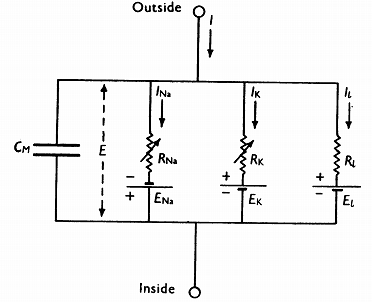

Figura 1

El diagrama de circuito en la Figura 1 muestra los componentes básicos de un elemento de membrana celular capacitiva con conducción iónica de sodio y potasio (con conductancia variable), además de una conductancia pasiva.
La corriente total se puede explicar como una suma de la corriente que carga la capacitancia de la membrana, más las corrientes debidas a cada especie iónica y la corriente pasiva. 
\begin{equation}
I_{ext} = -C_m \frac{dE}{dt} + I_{Na} + I_{K}+ I_{l}
\end{equation}
donde $E$ es el voltaje a través de la membrana celular, $C_m$ es la capacitancia de la membrana, $I_{Na}$ e $I_{K}$ son la corriente por los canales de sodio y potasio respectivamente, $I_l$ es una corriente agregada de otros canales (subíndice del inglés *leak*), e $I_{ext}$ es la corriente externa que se aplica a la membrana en un experimento (puede tener valor 0 para representar una célula sin perturbaciones). 

Las corrientes iónicas se modelan como 
\begin{equation}
I_{Na} = (E-E_{Na}) G_{Na} m^3 h
\end{equation}
\begin{equation}
I_{K} = (E-E_{K}) G_{K} n^4
\end{equation}
\begin{equation}
I_{l} = (E-E_{l}) G_{l}
\end{equation}
donde las constantes $G_{Na}$, $G_{K}$ son la conductancia del canal respectivo cuando está abierto, y donde $m$, $h$, $n$ son variables de estado que modelan el comportamiento dinámico de la probabilidad de activación ($m$) e inactivación ($h$) de los canales de sodio, y de la activación ($n$) de los canales de potasio. El exponente de cada variable de estado obedece a la cantidad de sub-unidades de la proteína en el canal iónico correspondiente, las que determinan la probabilidad total de que el canal esté abierto. La conductancia $G_l$ atribuída a otros elementos (no sodio ni potasio) se asume que no cambia con el tiempo, por lo que $I_l$ no tiene variables de estado. Estas variables se modelan como
\begin{equation}
\frac{dm}{dt} = \alpha_{m}(1-m) - \beta_{m}m
\end{equation}
\begin{eqnarray}
\alpha_{m} &= &\frac{A(E(t)-B)}{1-e^{(B-E(t))/C}}\\
\beta_{m} &= &\frac{A(B-E(t))}{1-e^{(E(t)-B)/C}}
\end{eqnarray}
donde $m$ es una variable entre 0 y 1 que representa la fracción de canales activados. $\alpha_m$ es la tasa de transición desde el estado inactivado al estado activado, y $\beta_m$ es la tasa de transición desde el estado activado al estado inactivado. $\alpha_m$ y $\beta_m$ a su vez son funcion de $E$, el voltaje en la membrana. $A$, $B$, $C$ son constantes que determinan el valor central, la pendiente y amplitud de la función sigmoide. Las ecuaciones son análogas para $m$, $h$, $n$, con diferentes valores de constantes $A$, $B$, $C$ en cada caso. En [este código](https://colab.research.google.com/drive/1reU_7BQ7stRk1jLjiPxROR42Hm5HMH8e) se puede ver una función de activación $\alpha$ y el rol de los parámetros $A$, $B$, $C$.

En nuestra simulación, todos los parámetros tienen valores conocidos. 

In [11]:
#@title Inicialización
# import some needed functions
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [12]:
#@title Parámetros

# set up a dictionary of parameters
E_params = { # external parameters
        'E_leak' : -7.0e-2,
        'G_leak' : 3.0e-09,
        'C_m'    : 3.0e-11,
        'I_ext'  : 0*1.0e-10
}

Na_params = {
        'Na_E'          : 5.0e-2,
        'Na_G'          : 1.0e-6,
        'k_Na_act'      : 3.0e+0,
        'A_alpha_m_act' : 2.0e+5,
        'B_alpha_m_act' : -4.0e-2,
        'C_alpha_m_act' : 1.0e-3,
        'A_beta_m_act'  : 6.0e+4,
        'B_beta_m_act'  : -4.9e-2,
        'C_beta_m_act'  : 2.0e-2,
        'l_Na_inact'    : 1.0e+0,
        'A_alpha_m_inact' : 8.0e+4,
        'B_alpha_m_inact' : -4.0e-2,
        'C_alpha_m_inact' : 1.0e-3,
        'A_beta_m_inact'  : 4.0e+2,
        'B_beta_m_inact'  : -3.6e-2,
        'C_beta_m_inact'  : 2.0e-3
}

K_params = {
        'k_E'           : -9.0e-2,
        'k_G'           : 2.0e-7,
        'k_K'           : 4.0e+0,
        'A_alpha_m_act' : 2.0e+4,
        'B_alpha_m_act' : -3.1e-2,
        'C_alpha_m_act' : 8.0e-4,
        'A_beta_m_act'  : 5.0e+3,
        'B_beta_m_act'  : -2.8e-2,
        'C_beta_m_act'  : 4.0e-4
}

stim_params = {
        'time1'         : 0,
        'duration1'     : 1e-3,
        'time2'         : 0,
        'duration2'     : 0
}

params = {
        'E_params'  : E_params,
        'Na_params' : Na_params,
        'K_params'  : K_params,
        'stim_params'      : stim_params
}

# ideal gas constant in J⋅K−1⋅mol−1.
R_gas = 8.31446261815324 
# temperature in kelvin
T_kelvin = 310
# charge of K+ ions
z_charge_k = 1
# faraday constant in C·mol−1
F_faraday = 96485.33212


Definir los parámetros en diccionarios permite obtenerlos fácilmente por el nombre:

In [13]:
E_params['C_m']

3e-11

In [14]:
#@title Ecuación diferencial { vertical-output: true, form-width: "20%" }

# define helper functions for each current, to generate them later again for plotting
def I_ext_fun(t, params):
        stim = params['stim_params']
        Ext  = params['E_params']

        # external current (from "voltage clamp", other compartments, other neurons, etc)
        I_ext = Ext['I_ext'] * ((stim['time1'] < t) * (t < stim['time1']+stim['duration1']) + (stim['time2'] < t) * (t < stim['time2']+stim['duration2']))
        return I_ext

def I_Na_fun(E, m, h, params):
        Na   = params['Na_params']
        # current due to Na ion
        I_Na =(Na['Na_E']-E) * Na['Na_G'] * (m**Na['k_Na_act']) * h
        return I_Na

def I_K_fun(E, n, params):
        K    = params['K_params']
        # current due to K ion
        I_K = (K['k_E']-E) * K['k_G'] * n**K['k_K']
        return I_K

# define our ODE function
def neuron(state, t, params):
        """
         Purpose: simulate Hodgkin and Huxley model for the action potential using
         the equations from Ekeberg et al, Biol Cyb, 1991.
         Input: state ([E m h n] (ie [membrane potential; activation of
                  Na++ channel; inactivation of Na++ channel; activation of K+
                  channel]),
                t (time),
                and the params (parameters of neuron; see Ekeberg et al).
         Output: statep (state derivatives).
        """

        E = state[0]
        m = state[1]
        h = state[2]
        n = state[3]

        Ext  = params['E_params']
        Na   = params['Na_params']
        K    = params['K_params']
        stim = params['stim_params']

        # external current (from "voltage clamp", other compartments, other neurons, etc)
        I_ext = I_ext_fun(t, params)
        # Na-current:
        I_Na = I_Na_fun(E, m, h, params)
        # K-current:
        I_K = I_K_fun(E, n, params)

        # calculate Na rate functions and I_Na
        alpha_act = Na['A_alpha_m_act'] * (E-Na['B_alpha_m_act']) / (1.0 - np.exp((Na['B_alpha_m_act']-E) / Na['C_alpha_m_act']))
        beta_act = Na['A_beta_m_act'] * (Na['B_beta_m_act']-E) / (1.0 - np.exp((E-Na['B_beta_m_act']) / Na['C_beta_m_act']) )
        dm_dt = ( alpha_act * (1.0 - m) ) - ( beta_act * m )

        alpha_inact = Na['A_alpha_m_inact'] * (Na['B_alpha_m_inact']-E) / (1.0 - np.exp((E-Na['B_alpha_m_inact']) / Na['C_alpha_m_inact']))
        beta_inact  = Na['A_beta_m_inact'] / (1.0 + (np.exp((Na['B_beta_m_inact']-E) / Na['C_beta_m_inact'])))
        dh_dt = ( alpha_inact*(1.0 - h) ) - ( beta_inact*h )

        # calculate K rate functions
        alpha_kal = K['A_alpha_m_act'] * (E-K['B_alpha_m_act']) / (1.0 - np.exp((K['B_alpha_m_act']-E) / K['C_alpha_m_act']))
        beta_kal = K['A_beta_m_act'] * (K['B_beta_m_act']-E) / (1.0 - np.exp((E-K['B_beta_m_act']) / K['C_beta_m_act']))
        dn_dt = ( alpha_kal*(1.0 - n) ) - ( beta_kal*n )

        # leak current
        I_leak = (Ext['E_leak']-E) * Ext['G_leak']

        # calculate derivative of E
        dE_dt = (I_leak + I_K + I_Na + I_ext) / Ext['C_m']
        dstate_dt = [dE_dt, dm_dt, dh_dt, dn_dt]

        return dstate_dt


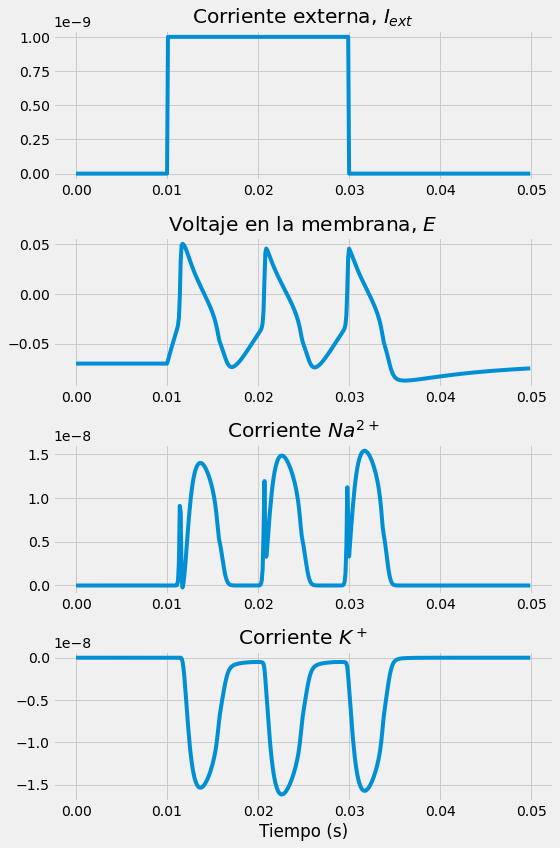

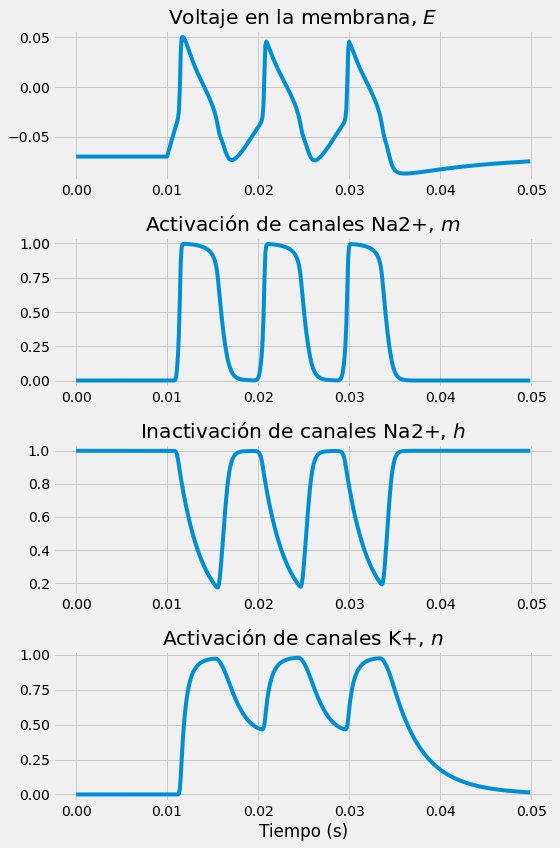

In [15]:
#@title Integración numérica y gráfico de solución { form-width: "30%" }

# set initial states and time vector
state0 = [-70e-03, 0, 1, 0]
t = np.arange(0, 50e-3, 0.1e-3)

# define parameters of external current injection
params['E_params']['I_ext'] = 10.0e-10
params['stim_params']['time1'] = 10e-3
params['stim_params']['duration1'] = 20e-3

# run simulation
state = odeint(neuron, state0, t, args=(params,))

Ext = params['E_params']
Na  = params['Na_params']
K   = params['K_params']
E   = state[:,0]
m   = state[:,1]
h   = state[:,2]
n   = state[:,3]
# external current (from "voltage clamp", other compartments, other neurons, etc)
I_ext = I_ext_fun(t, params)
# Na-current:
I_Na = I_Na_fun(E, m, h, params)
# K-current:
I_K = I_K_fun(E, n, params)

plt.figure(figsize=(8,12))
plt.subplot(4,1,1)
plt.plot(t, I_ext)
plt.title('Corriente externa, $I_{ext}$')
plt.subplot(4,1,2)
plt.plot(t, E)
plt.title('Voltaje en la membrana, $E$')
plt.subplot(4,1,3)
plt.plot(t, I_Na)
plt.title('Corriente $Na^{2+}$')
plt.subplot(4,1,4)
plt.plot(t, I_K)
plt.title('Corriente $K^+$')
plt.xlabel('Tiempo (s)')

plt.tight_layout()

plt.figure(figsize=(8,12))
plt.subplot(4,1,1)
plt.plot(t, E)
plt.title('Voltaje en la membrana, $E$')
plt.subplot(4,1,2)
plt.plot(t, m)
plt.title('Activación de canales Na2+, $m$')
plt.subplot(4,1,3)
plt.plot(t, h)
plt.title('Inactivación de canales Na2+, $h$')
plt.subplot(4,1,4)
plt.plot(t, n)
plt.title('Activación de canales K+, $n$')
plt.xlabel('Tiempo (s)')

plt.tight_layout()


# Problema 1 (3 ptos)

En este ejercicio simulará el potencial de acción en condiciones de hiperkalemia. La hiperkalemia consiste en un aumento de la concentraciones de iones de potasio en el medio extracelular lo que provoca una disminución del potencial de equilibrio de la célula, contribuyendo a disminuir el potencial de "descanso" de la célula.

El código a continuación realiza una simulación con estímulo externo constante de 0.5 nA. La variable *k_out* indica la concentración extracelular de potasio en mM. 

Para simular hiperkalemia realice simulaciones con distintos valores de concentración de potasio extracelular y grafíquelas todas en un mismo gráfico. 
Modifique esta variable en pasos de 5 mM para generar sus simulaciones. 
Para este ejercicio, considere que el valor normal de potasio extracelular es 5 mM y el valor elevado puede llegar hasta 35 mM. 

Luego de la simulación responda:

1. ¿Cuáles son las principales causas de la hiperkalemia? (0.5 pto)
2. ¿Qué efectos puede tener la hiperkalemia en el cuerpo humano y por qué? (0.5 pto)

3. En base a los gráficos, ¿En qué afecta la hiperkalemia a los voltajes mínimo y máximo, y amplitud alcanzados durante la oscilación periódica de potenciales de acción de la membrana celular? (1pto)
4. ¿Qué efectos se observan en el ritmo de la oscilación? ¿En qué se diferencian los efectos de la concentración de potasio extracelular en los rangos 5-20 mM, 20-25 mM, y 30-35 mM? (1 pto)

* Nota: Si utilizó fuentes para sus análisis, no olvide citarlas.

* Nota 2: Debido a que esta es una simulación simplificada de potenciales de acción celulares, algunos detalles no representan fielmente el caso humano, como la duración y forma del potencial de acción, y los valores de concentraciones iónicas. Los efectos cualitativos de concentraciones iónicas si son comparables.


In [16]:
# K+ concentrations
k_in = 140
k_out = 5
# K equilibrium potential
k_E = (R_gas*T_kelvin)/(z_charge_k*F_faraday) * np.log(k_out/k_in)
print(k_E)

-0.08901562196464294


C:\Users\ivanv\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:59: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


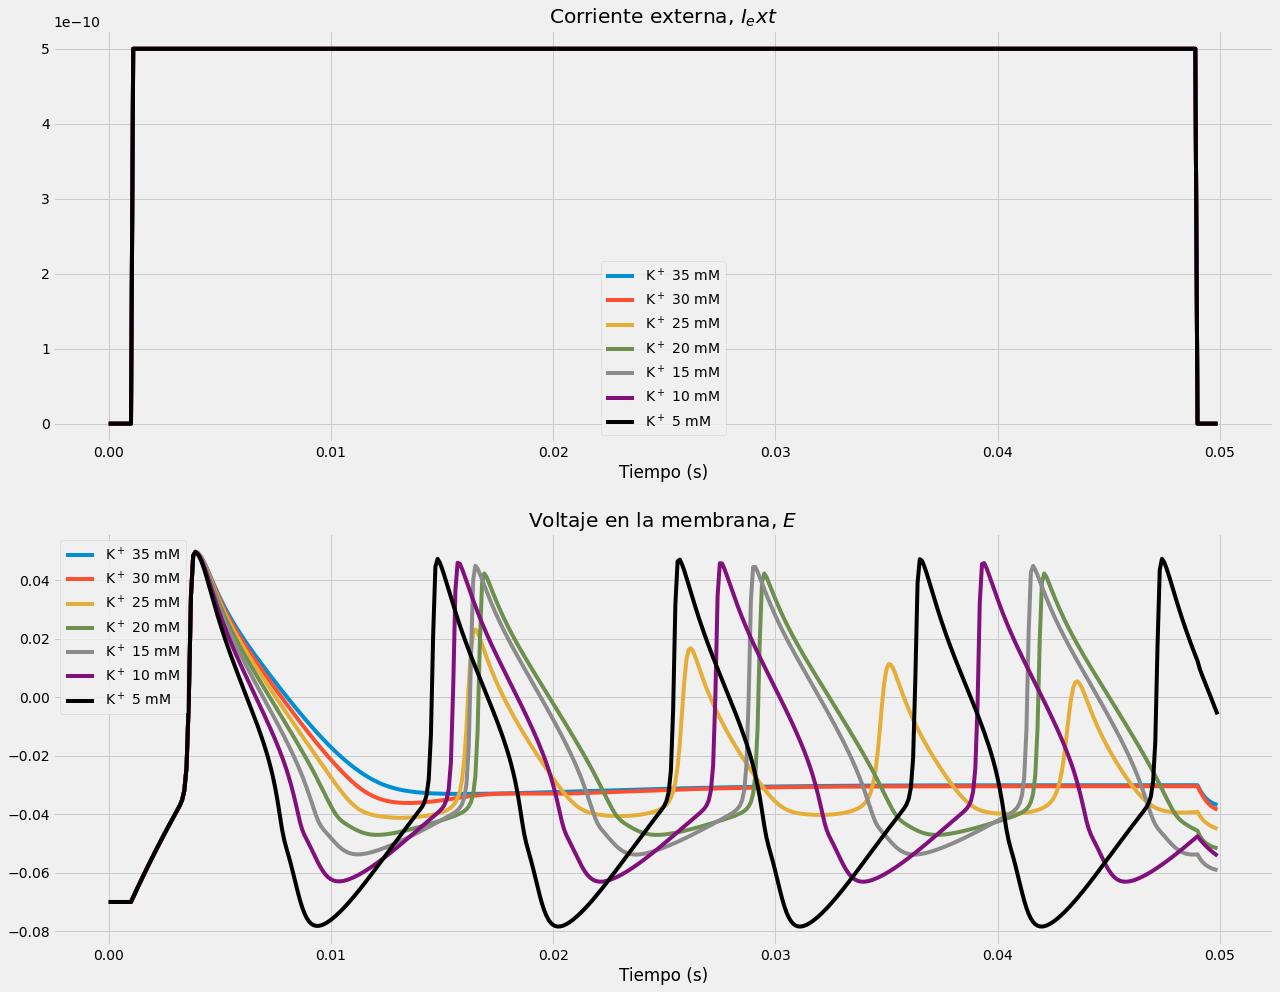

In [17]:
# set initial states and time vector
state0 = [-70e-03, 0, 1, 0]
t = np.arange(0, 50e-3, 0.1e-3)

# define constant external current stimulus that generates periodic action potentials
params['E_params']['I_ext'] = 5.0e-10
params['stim_params']['time1'] = 1e-3
params['stim_params']['duration1'] = 48e-3
params['stim_params']['time2'] = 0e-3
params['stim_params']['duration2'] = 0e-3

fig, ax = plt.subplots(2, 1, figsize=(18,14))
plt.style.use('fivethirtyeight')
k_concentrations = tuple(range(5, 36, 5))[::-1]
k_in = 140

for k_out in k_concentrations:
    # define the K equilibrium potential given by nominal K concentrations. 
    k_E = (R_gas*T_kelvin)/(z_charge_k*F_faraday) * np.log(k_out/k_in)
    params['K_params']['k_E'] = k_E

    # run simulation
    state = odeint(neuron, state0, t, args=(params,))

    Ext  = params['E_params']
    Na   = params['Na_params']
    K    = params['K_params']
    E = state[:,0]
    m = state[:,1]
    h = state[:,2]
    n = state[:,3]
    # external current (from "voltage clamp", other compartments, other neurons, etc)
    I_ext = I_ext_fun(t, params)
    # Na-current:
    I_Na = I_Na_fun(E, m, h, params)
    # K-current:
    I_K = I_K_fun(E, n, params)

    if k_out == 5:
        ax[0].plot(t, I_ext, label = r'K$^+$ ' + str(k_out) + ' mM', color = 'k')

        ax[1].plot(t, E, label = r'K$^+$ ' + str(k_out) + ' mM', color = 'k')
    
    else:
        ax[0].plot(t, I_ext, label = r'K$^+$ ' + str(k_out) + ' mM')

        ax[1].plot(t, E, label = r'K$^+$ ' + str(k_out) + ' mM')


ax[0].set_title('Corriente externa, $I_ext$')
ax[0].set_xlabel('Tiempo (s)')

ax[1].set_title('Voltaje en la membrana, $E$')
ax[1].set_xlabel('Tiempo (s)')

ax[0].legend()
ax[1].legend()
fig.tight_layout(h_pad = 2)
fig.show()


1. Las principales causas de la hiperkalemia son el consumo de fármacos ahorradores de potasio, aporte excesivo de calcio, insuficiencia renal o suprarrenal y trastornos dedegradación celular. Fuente: [Manual MSD](https://www.msdmanuals.com/es-cl/professional/trastornos-endocrinol%C3%B3gicos-y-metab%C3%B3licos/trastornos-electrol%C3%ADticos/hiperpotasemia#:~:text=Las%20causas%20comunes%20de%20hiperpotasemia,blandos%20o%20el%20tubo%20digestivo).

2. La hiperkalemia suele ser asintomática hasta que, en casos graves, se generan arritmas cardiacas, aunque en algunos casos se puede presentar parálisis flácida o debilidad muscular. Fuente: [redacción médica](https://www.redaccionmedica.com/recursos-salud/diccionario-enfermedades/hiperpotasemia).

3. Como se aprecia en el gráfico, cuando la concentración de potasio aumenta, el voltaje máximo alcanzado disminuye y el voltaje mínimo aumenta, hasta que en las concentraciones sobre 30 mM se deja de conducir potencial por la membrana. En cuanto a las amplitudes, se puede observar que para el caso de 5mM se mantiene constante todo el tiempo mientras que para los otros valores, a excepcion de 30 - 35 mM, la amplitud, es decir distancia entre cada monte de la oscilación, va aumentando cuando pasa el tiempo.

4. El ritmo de la oscilación va disminuyendo mientras aumenta la concentración de potasio. En el rango de 5 - 20 mM, los voltajes máximos varian muy poco pero los voltajes mínimos aumentan de manera significativa. Para los 25 mM, el voltaje máximo disminuye de manera brusca y el voltaje mínimo se aproxima a 0. Para el rango de 30 - 35 mM, la membrana deja de conducir voltaje.


# Problema 2 (3 ptos)

Explore el concepto de umbral de disparo de un potencial de accion. Cuando el voltaje en la membrana alcanza un cierto valor, se genera un potencial de acción. Adapte el código de ejemplo a continuación para encontrar el valor del umbral de disparo. El código de ejemplo define una corriente de estimulacion con duracion de 0.5 ms y amplitud de 1 nA. 

En un sólo gráfico, genere varias simulaciones modificando la amplitud del estímulo en pasos de $\pm$ 0.1 nA hasta observar la generación de un potencial de acción. 

Explique su razonamiento para responder las preguntas:

1. ¿A qué se refiere el concepto de umbral en la generación de un potencial de acción? ¿Qué sucede en la membrana cuando se supera este valor? (1 pto)

2.  ¿Qué amplitud de corriente es necesaria para generar un potencial de acción? (0.5 pto)
3.  ¿Qué voltaje máximo se alcanza **sin generar** un potencial de acción? (0.5 pto)
4.  ¿Cómo cambian estos valores si la duración del pulso es 1 ms? ¿Y para 2 ms? (1 pto)



## Código de ejemplo

C:\Users\ivanv\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:55: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


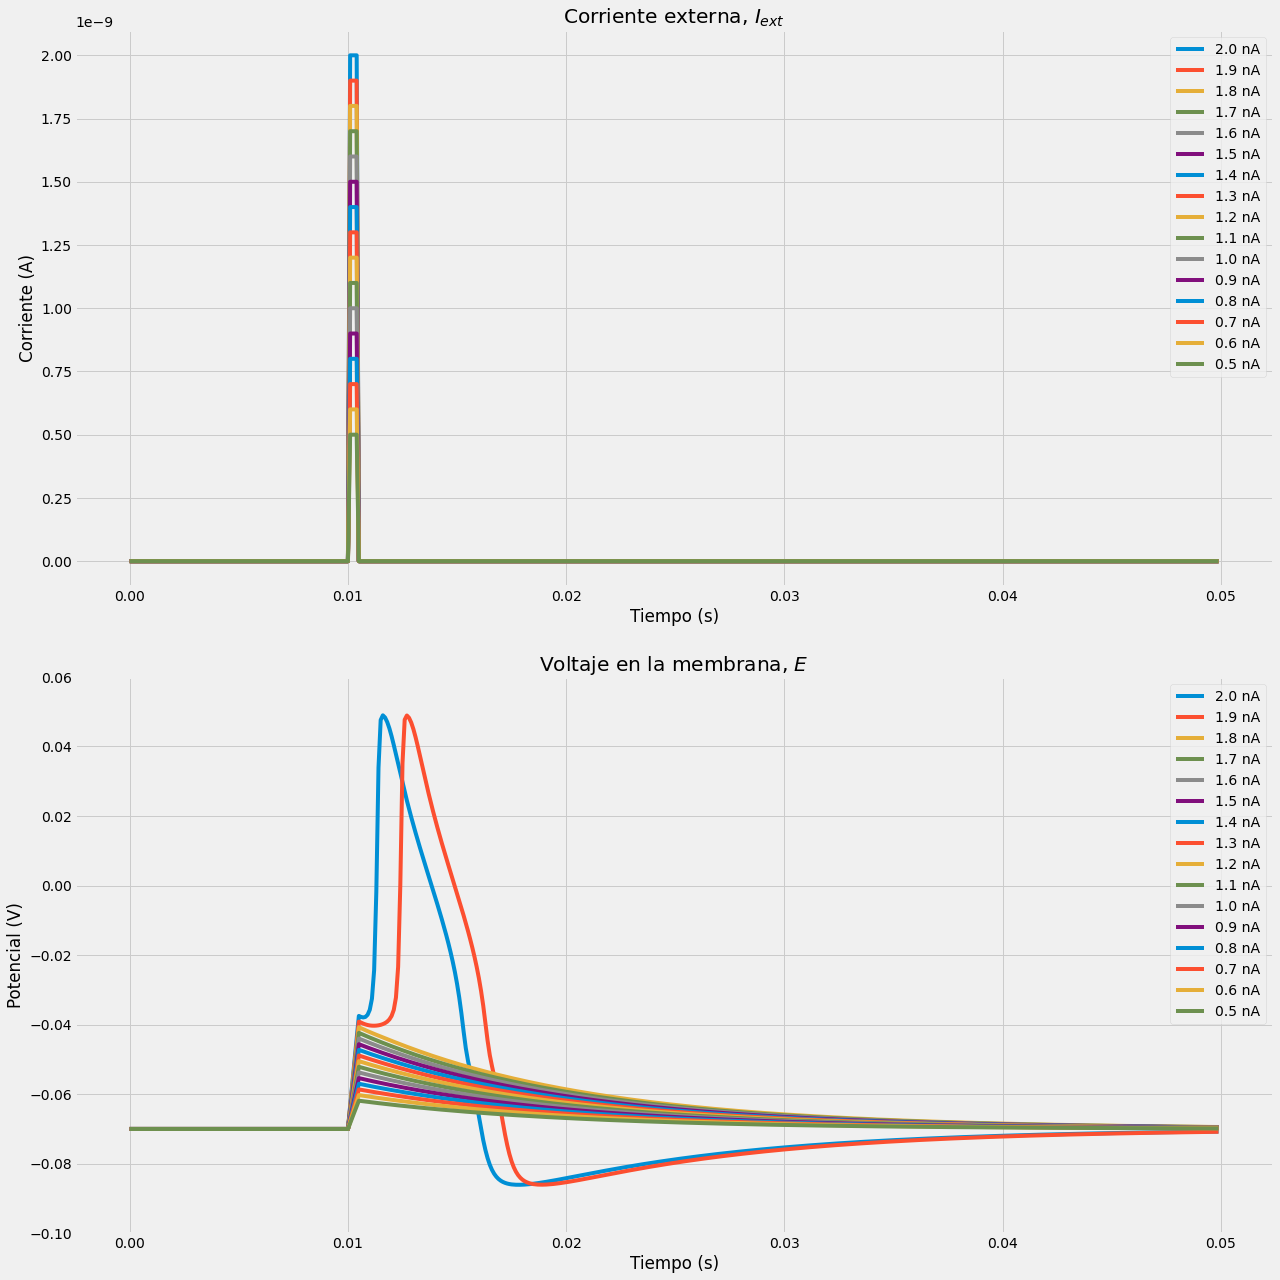

In [18]:
# set initial states and time vector
state0 = [-70e-03, 0, 1, 0]
t = np.arange(0, 50e-3, 0.1e-3)

corrientes = [i / (10 ** 10) for i in range(-5, 11, 1)][::-1]

params['stim_params']['time1'] = 10e-3
params['stim_params']['duration1'] = 0.5e-3
params['stim_params']['time2'] = 0
params['stim_params']['duration2'] = 0

fig, ax = plt.subplots(2,1,figsize=(18,18))
plt.style.use('fivethirtyeight')

for corriente in corrientes:
    # let's inject some external current
    params['E_params']['I_ext'] = 1e-9 + corriente

    # run simulation
    state = odeint(neuron, state0, t, args=(params,))

    Ext  = params['E_params']
    Na   = params['Na_params']
    K    = params['K_params']
    E = state[:,0]
    m = state[:,1]
    h = state[:,2]
    n = state[:,3]
    # external current (from "voltage clamp", other compartments, other neurons, etc)
    I_ext = I_ext_fun(t, params)
    # Na-current:
    I_Na = I_Na_fun(E, m, h, params)
    # K-current:
    I_K = I_K_fun(E, n, params)
    
    label = str((1e-9 + corriente) * 10 ** 9)[:3]

    ax[0].plot(t, I_ext, label = f'{label} nA')
    
    ax[1].plot(t, E, label = f'{label} nA')


ax[0].set_title('Corriente externa, $I_{ext}$')
ax[0].set_xlabel('Tiempo (s)')
ax[0].set_ylabel('Corriente (A)')

ax[1].set_title('Voltaje en la membrana, $E$')
ax[1].set_xlabel('Tiempo (s)')
ax[1].set_ylabel('Potencial (V)')
ax[1].set_ylim([-0.1, 0.06])

ax[0].legend()
ax[1].legend()
plt.tight_layout(h_pad = 2)
fig.show()

1. El umbral en la generación de un potencial de acción corresponde al valor límite para el cual se genera la despolarización de la membrana, cuando esto ocurre, comienza la transmisión de señales eléctricas entre membranas de células conlindantes, lo que establece una relación en cadena de comunicación celular, que se ve reflejada en cambios en la permeabilidad de las membranas, entre otras reacciones. Fuentes: [FisioOnline](https://www.fisioterapia-online.com/glosario/potencial-de-accion), [Access Medicina](https://accessmedicina.mhmedical.com/content.aspx?bookId=1501&sectionId=101805483).

2. En este caso, con una duración de 0.5 ms, la amplitud de corriente necesaria para generar un potencial de acción es de $1.9 \, nA$.

3. Sin alcanzar a generar un potencial de acción, es decir, con una amplitud de corriente menor a $1.9 \, nA$, el voltaje máximo alcanzado es de $-0.04 \, V$ aproximadamente.

4. A continuación se presentan los gráficos para duraciones del pulso de 1 ms y 2 ms, respectivamente.


C:\Users\ivanv\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:55: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


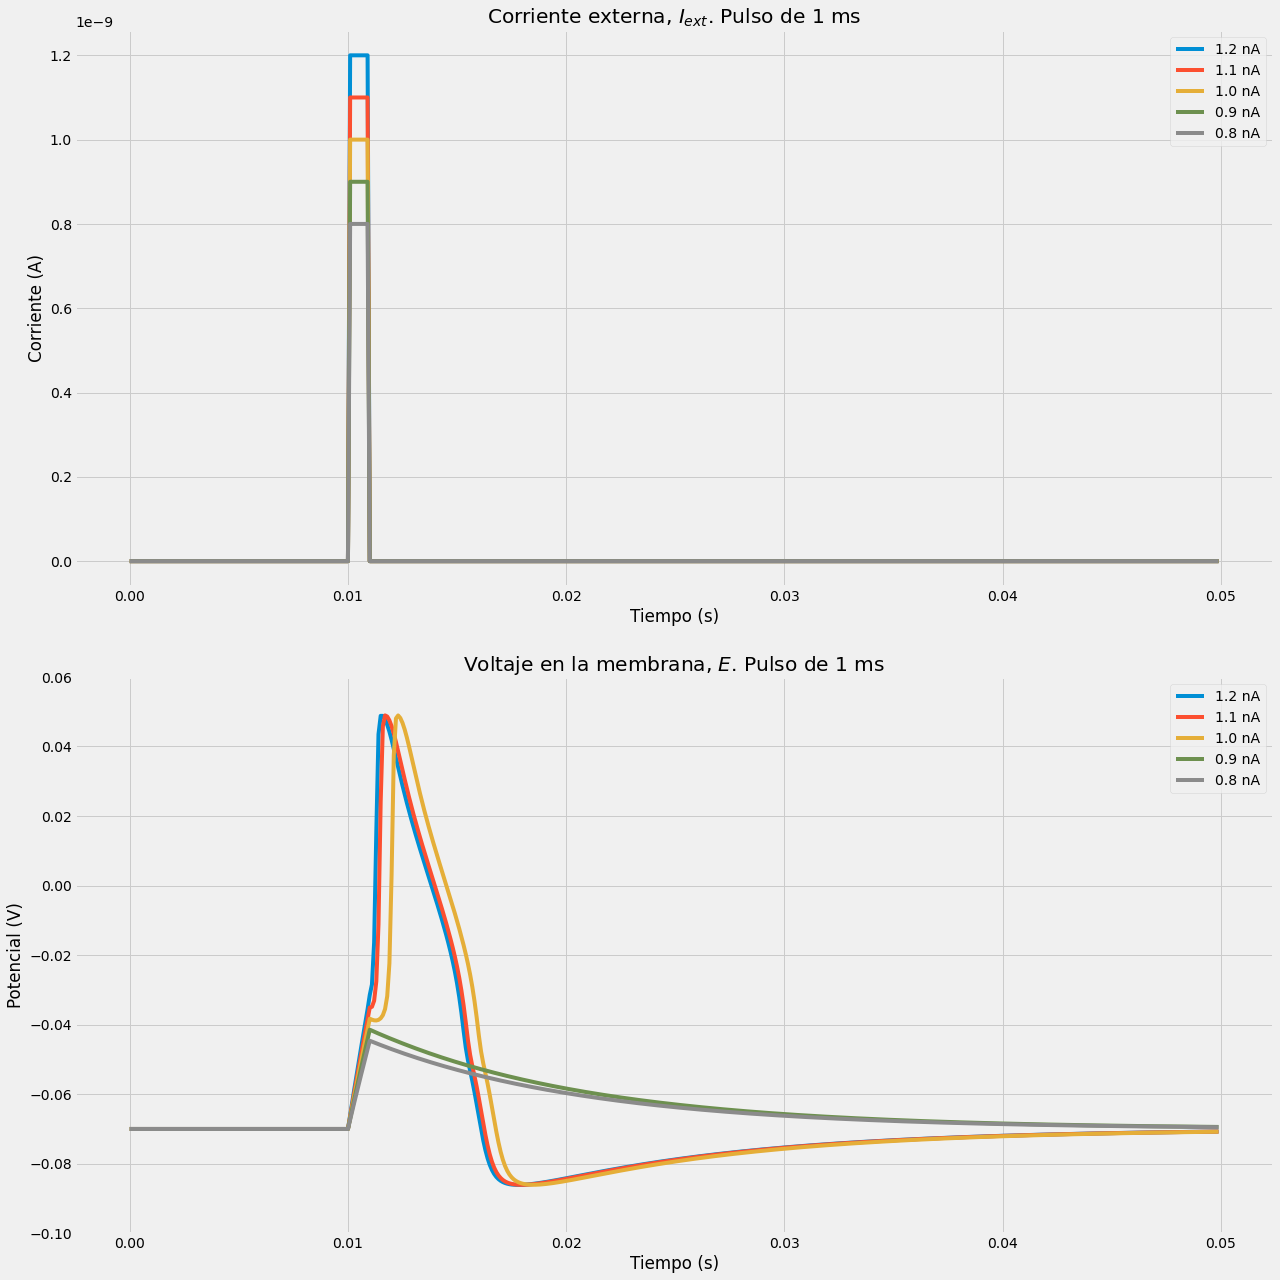

In [19]:
# set initial states and time vector
state0 = [-70e-03, 0, 1, 0]
t = np.arange(0, 50e-3, 0.1e-3)

corrientes = [i / (10 ** 10) for i in range(-2, 3, 1)][::-1]

params['stim_params']['time1'] = 10e-3
params['stim_params']['duration1'] = 1e-3
params['stim_params']['time2'] = 0
params['stim_params']['duration2'] = 0

fig, ax = plt.subplots(2,1,figsize=(18,18))
plt.style.use('fivethirtyeight')

for corriente in corrientes:
    # let's inject some external current
    params['E_params']['I_ext'] = 1e-9 + corriente

    # run simulation
    state = odeint(neuron, state0, t, args=(params,))

    Ext  = params['E_params']
    Na   = params['Na_params']
    K    = params['K_params']
    E = state[:,0]
    m = state[:,1]
    h = state[:,2]
    n = state[:,3]
    # external current (from "voltage clamp", other compartments, other neurons, etc)
    I_ext = I_ext_fun(t, params)
    # Na-current:
    I_Na = I_Na_fun(E, m, h, params)
    # K-current:
    I_K = I_K_fun(E, n, params)
    
    label = str((1e-9 + corriente) * 10 ** 9)[:3]

    ax[0].plot(t, I_ext, label = f'{label} nA')
    
    ax[1].plot(t, E, label = f'{label} nA')


ax[0].set_title('Corriente externa, $I_{ext}$. Pulso de 1 ms')
ax[0].set_xlabel('Tiempo (s)')
ax[0].set_ylabel('Corriente (A)')

ax[1].set_title('Voltaje en la membrana, $E$. Pulso de 1 ms')
ax[1].set_xlabel('Tiempo (s)')
ax[1].set_ylabel('Potencial (V)')
ax[1].set_ylim([-0.1, 0.06])

ax[0].legend()
ax[1].legend()
plt.tight_layout(h_pad = 2)
fig.show()

C:\Users\ivanv\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:56: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


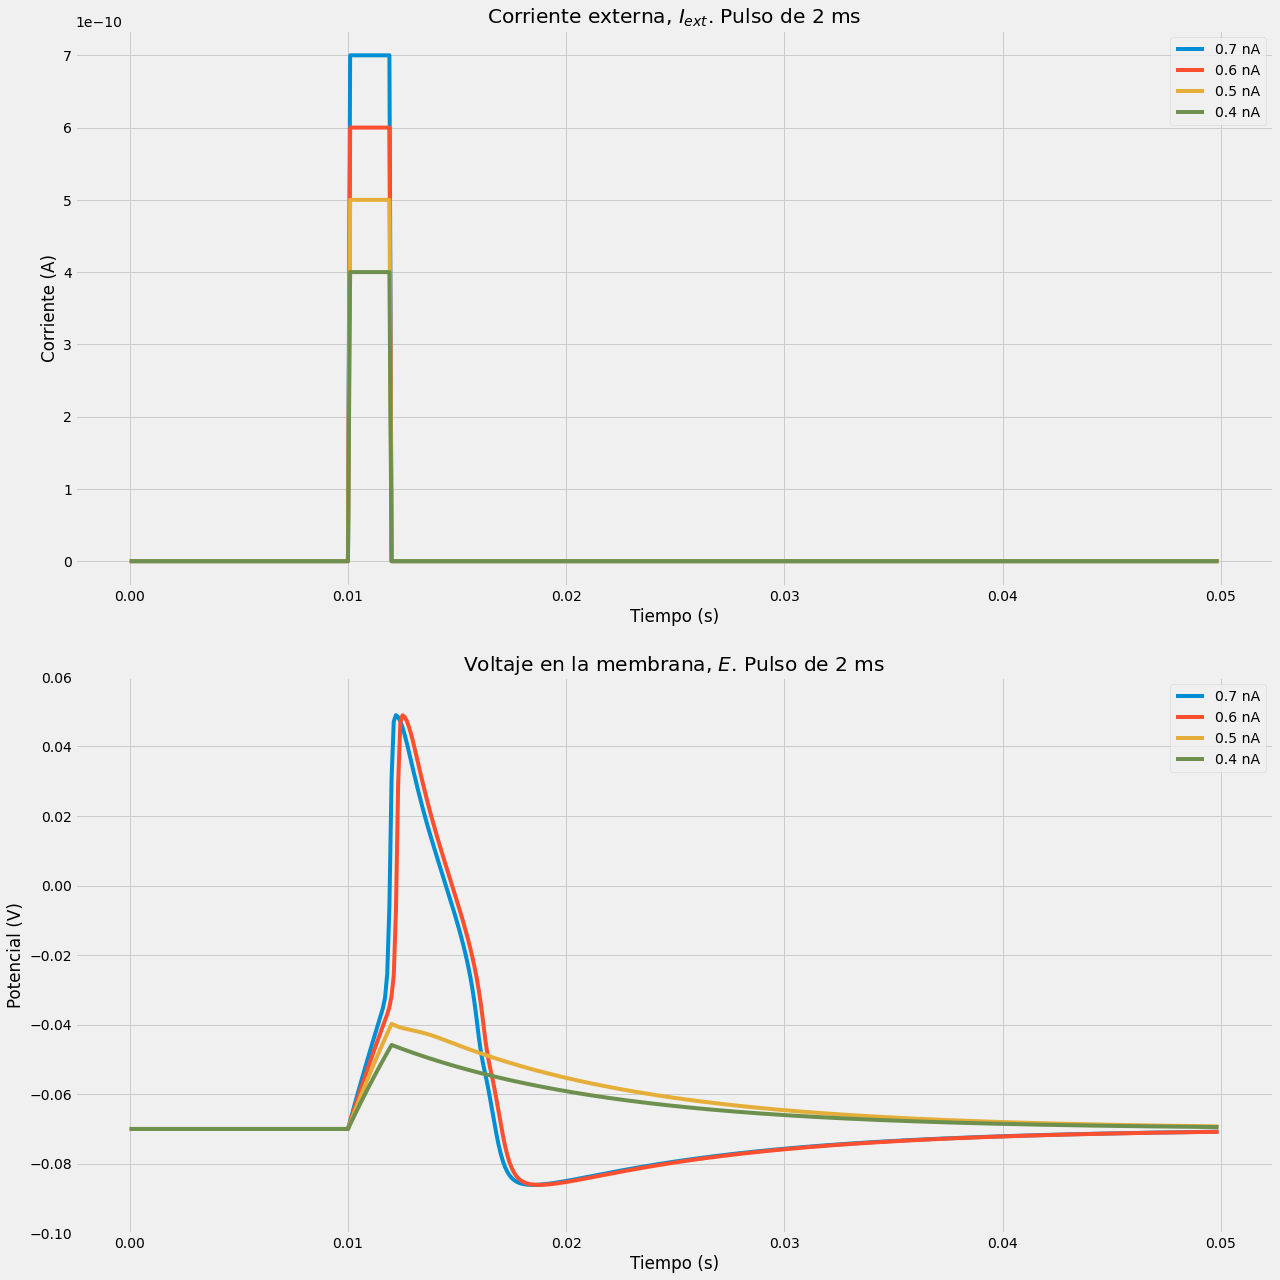

In [20]:
# set initial states and time vector
state0 = [-70e-03, 0, 1, 0]
t = np.arange(0, 50e-3, 0.1e-3)

corrientes = [i / (10 ** 10) for i in range(-6, -2, 1)][::-1]

params['stim_params']['time1'] = 10e-3
params['stim_params']['duration1'] = 2e-3
params['stim_params']['time2'] = 0
params['stim_params']['duration2'] = 0

fig, ax = plt.subplots(2,1,figsize=(18,18))
plt.style.use('fivethirtyeight')

for corriente in corrientes:
    # let's inject some external current
    params['E_params']['I_ext'] = 1e-9 + corriente

    # run simulation
    state = odeint(neuron, state0, t, args=(params,))

    Ext  = params['E_params']
    Na   = params['Na_params']
    K    = params['K_params']
    E = state[:,0]
    m = state[:,1]
    h = state[:,2]
    n = state[:,3]
    # external current (from "voltage clamp", other compartments, other neurons, etc)
    I_ext = I_ext_fun(t, params)
    # Na-current:
    I_Na = I_Na_fun(E, m, h, params)
    # K-current:
    I_K = I_K_fun(E, n, params)
    
    label = str((1e-9 + corriente) * 10 ** 9)[:3]

    ax[0].plot(t, I_ext, label = f'{label} nA')

    ax[1].plot(t, E, label = f'{label} nA')


ax[0].set_title('Corriente externa, $I_{ext}$. Pulso de 2 ms')
ax[0].set_xlabel('Tiempo (s)')
ax[0].set_ylabel('Corriente (A)')

ax[1].set_title('Voltaje en la membrana, $E$. Pulso de 2 ms')
ax[1].set_xlabel('Tiempo (s)')
ax[1].set_ylabel('Potencial (V)')
ax[1].set_ylim([-0.1, 0.06])

ax[0].legend()
ax[1].legend()
plt.tight_layout(h_pad = 2)
fig.show()

4. Para el pulso de 1 ms, los valores obtenidos fueron:
-  Amplitud de corriente necesaria para generar un potencial de acción: $1 \, nA$
- Voltaje máximo alcanzado sin alcanzar a generar un potencial de acción: $-0.04 \, V$ aproximadamente.

    Mientras que, para el pulso de 2 ms, los valores obtenidos fueron:
    
-  Amplitud de corriente necesaria para generar un potencial de acción: $0.6 \, nA$
- Voltaje máximo alcanzado sin alcanzar a generar un potencial de acción: $-0.04 \, V$ aproximadamente.

# Consideraciones generales

Para la entrega de su tarea tengan en cuenta las siguientes consideraciones:



1. La entrega de la tarea se realiza por medio del buzón de tareas de Canvas. Deben cargar un archivo por pareja en el formato **Pareja_X_TareaInstrumentacion.ipynb** con **X** el número de la pareja. Quienes no respeten el formato tendrán un descuento de 5 décimas en la nota final.  

2. En la revisión se consideran descuentos por falta de ortografías o por falta de fuentes de información no incluida en la tarea o las clases. Con un link basta para citar.

3. El plazo de entrega es hasta el **jueves 20 de mayo** a las **23:59 hrs**. Se considerarán descuentos de 0.5 puntos por cada hora o fracción de atraso en la entrega, sin excepciones. 